# Лабораторная работа №2

## Применение многослойной нейронной сети для аппроксимации функций


> <span style="font-style:normal; font-size:12pt;"> 
    <p> Цель работы: изучение математической модели многослойной нейронной сети и решение с её помощью задачи аппроксимации функций.
    </p>

<span style="font-style:normal; font-size:12pt;"> 
    <p> Аппроксимируемая функция </p>

$$
f(x)=3sin(5x)+x
$$

> <span style="font-style:normal; font-size:11pt;">
    <p>
        Проводим два эксперимента: в первом строим модель, во втором - улучшаем модель.
        В эксперименте-1 исследуем две модели: до и после обучения.
    </p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers

from sklearn.model_selection import train_test_split

import keras.backend as K

# import keras.models as M
# import keras.layers as L

# from sklearn.metrics import accuracy_score

In [2]:
def show_graph(*data3d,
               ax_xlabel, ax_ylabel, 
               title, dots=False, filename=None):
    x_plots = data3d[0]
    y_plots = data3d[1]
    labels_plots = data3d[2]
    
    fig, ax = plt.subplots(figsize=(14, 6))

    if dots:
        for index in range(len(x_plots)):
            ax.scatter(x_plots[index], y_plots[index], lw = 2, label=labels_plots[index])                
    else:
        for index in range(len(x_plots)):
            line,   = plt.plot(x_plots[index], y_plots[index], lw = 2, label=labels_plots[index])

    ax.set_xlabel(ax_xlabel, fontsize=14)
    ax.set_ylabel(ax_ylabel, fontsize=14)
    ax.set_title(title,      fontsize=14)

    plt.legend(fontsize=12)

    if filename:
        plt.savefig(f"./Graphs/{filename}.jpg")

    plt.show()

In [3]:
def build_model(units, active_fun, 
                kernel_initializer, bias_initializer,
                optimizer):
     # инициализация модели
    input1 = layers.Input(shape=(1,))

    # скрытый слой
    x = layers.Dense(
        units,
        activation=active_fun,
        kernel_initializer=kernel_initializer,
        bias_initializer  =bias_initializer)(input1)

    # выходной слой
    out_x = layers.Dense(
        1,
        kernel_initializer=kernel_initializer,
        bias_initializer  =bias_initializer)(x)
    
    
    # Соберем полную модель сети от входа к выходу
    model1 = Model(inputs=input1, outputs=out_x)
    

    # Компиляция модели
    model1.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(),
                 tf.keras.metrics.MeanSquaredError(),
                 tf.keras.metrics.RootMeanSquaredError(),
                'accuracy'])
    
    return model1

In [4]:
# def gaussian(x):
#     return K.exp(-K.pow(x,2))

def sin_activation(x):
    return K.sin(x)

## Исходная функция

In [5]:
# Аппроксимируемая функция

def f(x):
    return 3 * np.sin(5 * x) + x

left  = 0
right = 10
h = 0.05

In [6]:
x0_plot = np.linspace(left, right, round((right - left) / h) + 1)
f_plot = [f(x) for x in x0_plot]

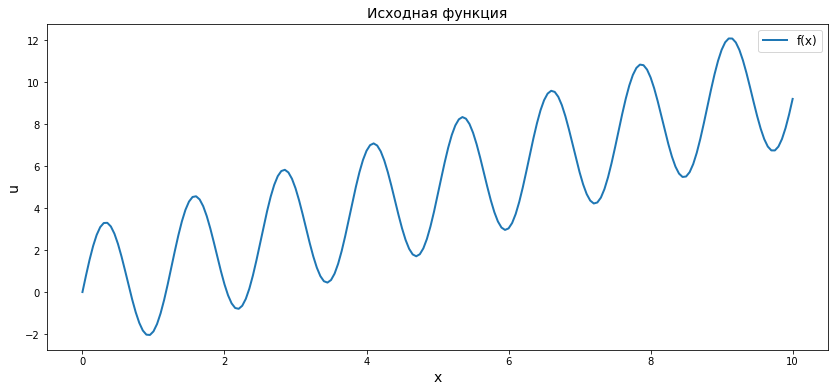

In [7]:
show_graph([x0_plot], [f_plot], ['f(x)'], 
           ax_xlabel='x', ax_ylabel='u',
           title='Исходная функция', dots=False, filename='Origin')

## Генерирование данных

In [8]:
x_plot = np.random.normal(5, 1.5, size=(1, 200))[0]
y_plot = np.asarray([f(x) for x in x_plot])

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_plot, y_plot, test_size=0.1)

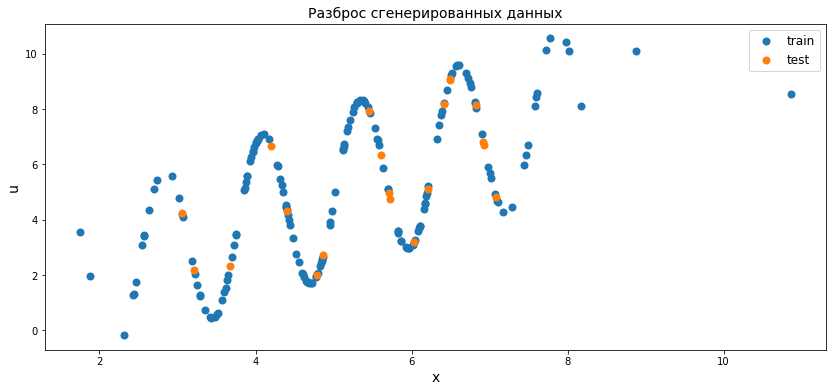

In [10]:
show_graph([x_train, x_test], [y_train,y_test], ['train', 'test'],           
           ax_xlabel='x', ax_ylabel='u',
           title='Разброс сгенерированных данных', dots=True)

<!-- # загрузка тренировачных и тестовых данных
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# конвертация числе из uint8 в float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# нормализация данных [0, 1]
x_train /= 255
x_test /= 255

# изменение размерности массива в 4D массив
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) -->

## Многослойная сеть

In [11]:
models      = {'exper_1':[], 'exper_2':[]}
predictions = {'exper_1':[], 'exper_2':[]}

In [12]:
# валидационная доля от тренеровачных данных
val_part = (len(x_plot) * 0.3 / len(x_plot)) / (len(x_plot) * 0.9 / len(x_plot))

In [13]:
# инициализация сети
kernel_initializer = tf.keras.initializers.RandomUniform(minval=-2.5, maxval=2.5, seed=None)
bias_initializer   = tf.keras.initializers.RandomUniform(minval=-2.5, maxval=2.5, seed=None)
    
# метод оптимизации
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

### Эксперимент-1

In [14]:
# параметры исследования
outputs1 = []
coefs1   = {'epochs': [], 'hidden': [], 'hidden_bias': [], 'out': [], 'out_bias':[]}
errors1  = {'epochs': [], 'train':[], 'val':[], 'test':[]}

#### 1. Сборка модели

In [15]:
for _ in range(2):
    model1_0 = build_model(64, sin_activation, 
                        kernel_initializer=kernel_initializer,
                        bias_initializer  =bias_initializer,
                        optimizer         =optimizer)
    
    models['exper_1'].append(model1_0)

#### 2. Обучение модели

In [16]:
model1_1 = models['exper_1'][1]

In [17]:
val_loss = 1000
epochs = 0

while val_loss > 0.5:
    
    hist1 = model1_1.fit(x=x_train, y=y_train, 
                      epochs=1, 
                      validation_split= val_part,  
                      batch_size=20)
    
    epochs += 1
    
    coefs1['epochs'].append(epochs)
    coefs1['hidden'].append(model1_1.layers[1].get_weights()[0])
    coefs1['hidden_bias'].append(model1_1.layers[1].get_weights()[1])
    coefs1['out'].append(model1_1.layers[2].get_weights()[0])
    coefs1['out_bias'].append(model1_1.layers[2].get_weights()[1])
    
    errors1['epochs'].append(epochs)
    errors1['train']. append(hist1.history['loss'])
    errors1['val'].   append(hist1.history['val_loss'])
    errors1['test'].  append(model1_1.evaluate(x_test, y_test, batch_size=20, verbose=0)[0])
    
    
    if hist1.history['val_loss'][0] < val_loss:
        val_loss = hist1.history['val_loss'][0]

6/6 [==============================] - 0s 11ms/step - loss: 1.1109 - mean_absolute_error: 0.7013 - mean_squared_error: 1.1109 - root_mean_squared_error: 1.0540 - accuracy: 0.0000e+00 - val_loss: 0.4517 - val_mean_absolute_error: 0.4546 - val_mean_squared_error: 0.4517 - val_root_mean_squared_error: 0.6721 - val_accuracy: 0.0000e+00


##### Сводка результатов

In [18]:
test_score1 = model1_1.evaluate(x_test, y_test, verbose=0)

print('\ntrain_MAE:  {:.4f}'.format(hist1.history['mean_absolute_error'][0]),      '\n' +
        'train_MSE:  {:.4f}'.format(hist1.history['mean_squared_error'][0]),       '\n' +
        'train_RMSE: {:.4f}'.format(hist1.history['root_mean_squared_error'][0]),  '\n' +
        'val_MAE:  {:.4f}'.format(hist1.history['val_mean_absolute_error'][0]),    '\n' +
        'val_MSE:  {:.4f}'.format(hist1.history['val_mean_squared_error'][0]),     '\n' +
        'val_RMSE: {:.4f}'.format(hist1.history['val_root_mean_squared_error'][0]),'\n' +
        'test_MAE:  {:.4f}'.format(test_score1[1]),      '\n' +
        'test_MSE:  {:.4f}'.format(test_score1[2]),      '\n' +
        'test_RMSE: {:.4f}'.format(test_score1[3]),      '\n' +
        'Accuracy {:.2f}%'.format(test_score1[4] * 100))


train_MAE:  0.7013 
train_MSE:  1.1109 
train_RMSE: 1.0540 
val_MAE:  0.4546 
val_MSE:  0.4517 
val_RMSE: 0.6721 
test_MAE:  0.3641 
test_MSE:  0.2288 
test_RMSE: 0.4783 
Accuracy 0.00%


In [19]:
y_predict_train = model1_1.predict(
    x_train,
    batch_size=20)

y_predict_test = model1_1.predict(
    x_test,
    batch_size=20)

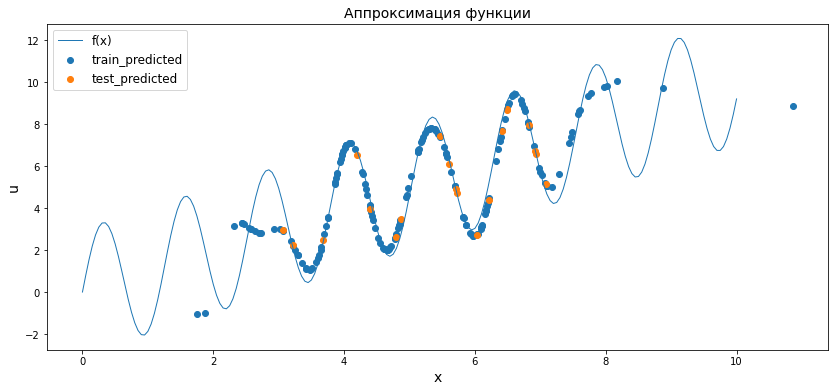

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

line,   = plt.plot(x0_plot, f_plot, lw = 1, label='f(x)')

ax.scatter(x_train, y_predict_train, label='train_predicted')
ax.scatter(x_test,  y_predict_test,  label='test_predicted')

ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('u', fontsize=14)
ax.set_title('Аппроксимация функции', fontsize=14)


plt.legend(fontsize=12)

plt.savefig(f"./Graphs/Exper1_approx.jpg")

plt.show()

### Эксперимент-2

#### 1. Сборка модели

In [21]:
# for _ in range(2):
#     model2_0 = build_model(32, sin_activation,
#                            kernel_initializer=kernel_initializer,
#                            bias_initializer  =bias_initializer,
#                            optimizer         =optimizer)
    
#     models['exper_2'].append(model2_0)  

#### 2. Обучение модели

In [22]:
# model2_1 = models['exper_2'][1]

In [23]:
# val_loss = 1000
# epochs = 0

# while val_loss > 0.1:
    
#     hist2 = model2_1.fit(x=x_train, y=y_train, 
#                       epochs=1, 
#                       validation_split= val_part,  
#                       batch_size=20)
    
#     epochs += 1
    
      
#     if hist2.history['val_loss'][0] < val_loss:
#         val_loss = hist2.history['val_loss'][0]

##### Сводка результатов

In [24]:
# test_score2= model2_1.evaluate(x_test, y_test, verbose=0)

# print('\ntrain_MAE:  {:.4f}'.format(hist2.history['mean_absolute_error'][0]),      '\n' +
#         'train_MSE:  {:.4f}'.format(hist2.history['mean_squared_error'][0]),       '\n' +
#         'train_RMSE: {:.4f}'.format(hist1.history['root_mean_squared_error'][0]),  '\n' +
#         'val_MAE:  {:.4f}'.format(hist2.history['val_mean_absolute_error'][0]),    '\n' +
#         'val_MSE:  {:.4f}'.format(hist2.history['val_mean_squared_error'][0]),     '\n' +
#         'val_RMSE: {:.4f}'.format(hist2.history['val_root_mean_squared_error'][0]),'\n' +
#         'test_MAE:  {:.4f}'.format(test_score2[1]),      '\n' +
#         'test_MSE:  {:.4f}'.format(test_score2[2]),      '\n' +
#         'test_RMSE: {:.4f}'.format(test_score2[3]),      '\n' +
#         'Accuracy {:.2f}%'.format(test_score2[4] * 100))

## Исследование зависимостей

### Эксперимент-1

#### 1. Регрессионная задача. Выход сети от входного сигнала

In [25]:
for i in range(2):

    model_i = models['exper_1'][i]

    y_predicted = model_i.predict(
        x_test,
        batch_size=20)

    predictions['exper_1'].append(y_predicted)

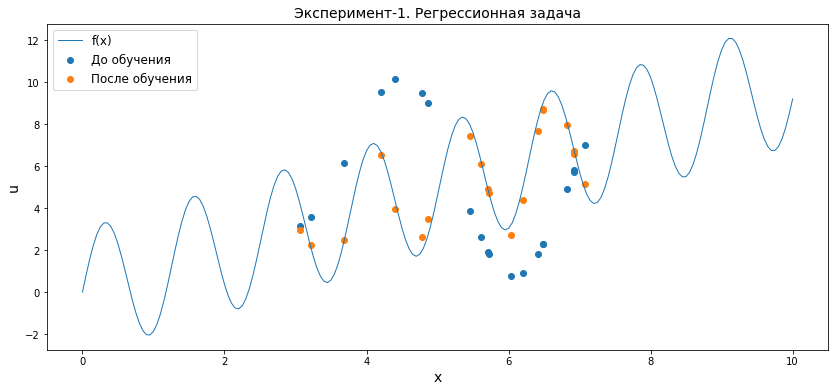

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))

line,   = plt.plot(x0_plot, f_plot, lw = 1, label='f(x)')

ax.scatter(x_test, predictions['exper_1'][0], label='До обучения')
ax.scatter(x_test, predictions['exper_1'][1], label='После обучения')

ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('u', fontsize=14)
ax.set_title('Эксперимент-1. Регрессионная задача', fontsize=14)


plt.legend(fontsize=12)

plt.savefig(f"./Graphs/Exper1.jpg")

plt.show()

#### 2. Ошибка на обучающей, валидационной и тестовой выборках

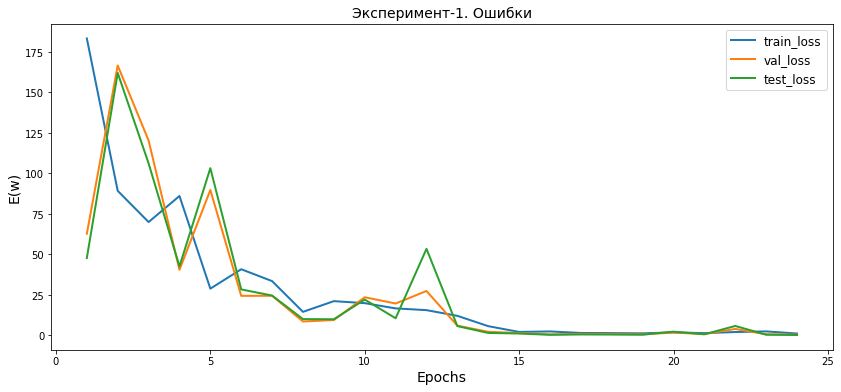

In [27]:
show_graph([errors1['epochs'], errors1['epochs'], errors1['epochs']], 
           [errors1['train'],  errors1['val'],    errors1['test']], 
           ['train_loss', 'val_loss', 'test_loss'],           
           ax_xlabel='Epochs', ax_ylabel='E(w)',
           title='Эксперимент-1. Ошибки', dots=False, filename='Errors1')

#### 3. Весовые коэффициенты

In [28]:
hiddenSize = coefs1['hidden'][0].size
hiddenSize

64

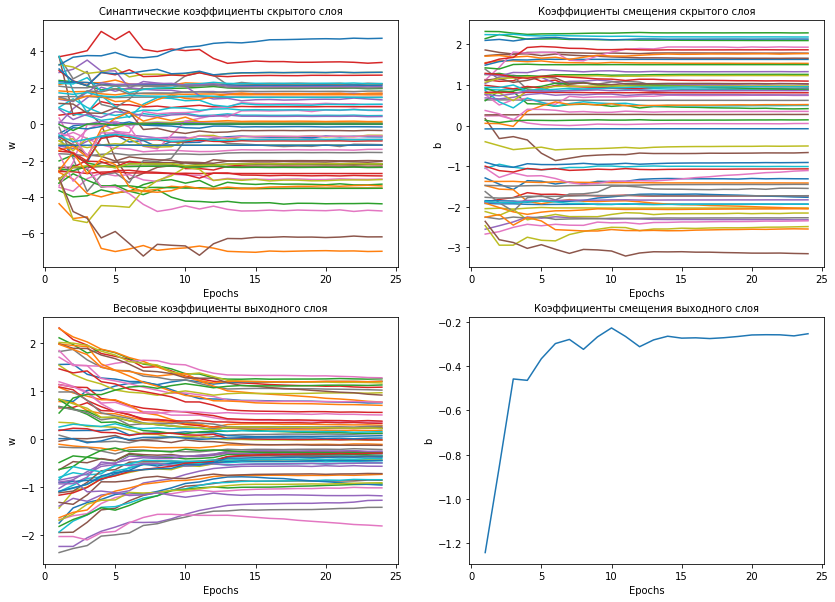

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

for i in range(hiddenSize):
    ff = [coefs[0][i] for coefs in coefs1['hidden']]
   
    ax1.plot(coefs1['epochs'], ff)
    ax1.set_title('Синаптические коэффициенты скрытого слоя', fontsize=10)
    
    ax1.set_xlabel('Epochs', fontsize=10)
    ax1.set_ylabel('w',      fontsize=10)
        

for i in range(hiddenSize):
    ff = [coefs[i] for coefs in coefs1['hidden_bias']]
    
    ax2.plot(coefs1['epochs'], ff)
    ax2.set_title('Коэффициенты смещения скрытого слоя', fontsize=10)
    
    ax2.set_xlabel('Epochs', fontsize=10)
    ax2.set_ylabel('b',      fontsize=10)
    
    
for i in range(hiddenSize):
    ff = [coefs[i][0] for coefs in coefs1['out']]
    
    ax3.plot(coefs1['epochs'], ff)
    ax3.set_title('Весовые коэффициенты выходного слоя', fontsize=10)
    
    ax3.set_xlabel('Epochs', fontsize=10)
    ax3.set_ylabel('w',      fontsize=10)
    

ff = [coefs[0] for coefs in coefs1['out_bias']]
    
ax4.plot(coefs1['epochs'], ff)
ax4.set_title('Коэффициенты смещения выходного слоя', fontsize=10)
    
ax4.set_xlabel('Epochs', fontsize=10)
ax4.set_ylabel('b',      fontsize=10)
   
    
plt.savefig(f"./Graphs/Weights1.jpg")
    
plt.show()

#### 4. Выходы скрытого слоя от входного сигнала

In [30]:
model1_0 = models['exper_1'][0]
model1_1 = models['exper_1'][1]

model1_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [31]:
layer_name1_0 = model1_0.get_layer(index=1).get_config()['name']
layer_name1_1 = model1_1.get_layer(index=1).get_config()['name']

In [32]:
inputs = [i*30 for i in range(6)]

model1_2  = Model(inputs=model1_0.input,
                 outputs=model1_0.get_layer(layer_name1_0).output)

output1_2 = model1_2.predict(inputs)


model1_3  = Model(inputs=model1_1.input,
                 outputs=model1_1.get_layer(layer_name1_1).output)

output1_3 = model1_3.predict(inputs)

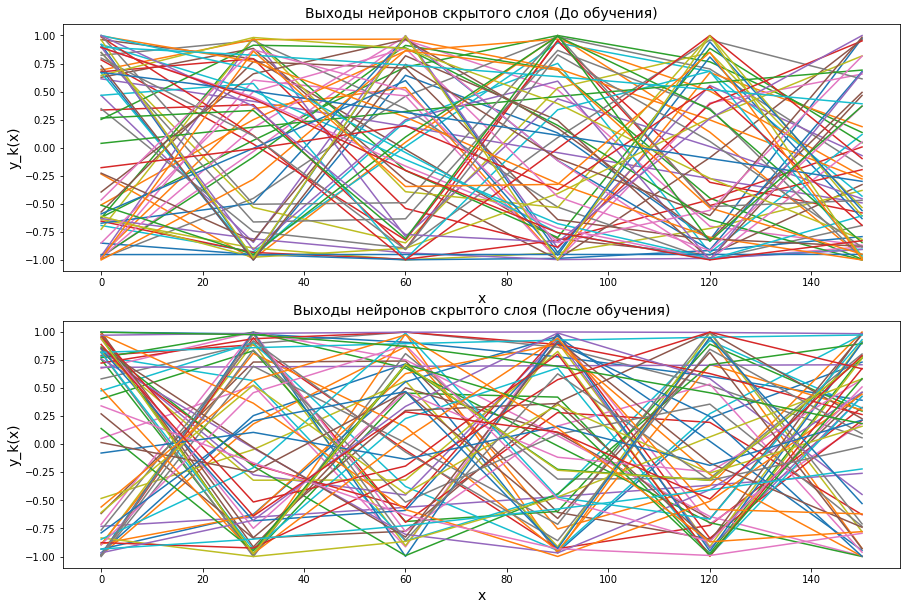

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

for i in range(hiddenSize):
    ff1 = [y[i] for y in output1_2]
    ax1.plot(inputs, ff1)
    ax1.set_title('Выходы нейронов скрытого слоя (До обучения)', fontsize=14)
    
    ax1.set_xlabel('x',      fontsize=14)
    ax1.set_ylabel('y_k(x)', fontsize=14)
    
    
for i in range(hiddenSize):
    ff2 = [y[i] for y in output1_3]
    ax2.plot(inputs, ff2)
    ax2.set_title('Выходы нейронов скрытого слоя (После обучения)', fontsize=14)
    
    ax2.set_xlabel('x',      fontsize=14)
    ax2.set_ylabel('y_k(x)', fontsize=14)
    

plt.savefig(f"./Graphs/Outputs_hidden1.jpg")
    
plt.show()

### Эксперимент-2

#### 1. Регрессионная задача. Выход сети от входного сигнала

In [34]:
# for i in range(2):

#     model_i = models['exper_2'][i]

#     y_predicted = model_i.predict(
#         x_test,
#         batch_size=20)

#     predictions['exper_2'].append(y_predicted)

In [35]:
# fig, ax = plt.subplots(figsize=(14, 6))

# line,   = plt.plot(x0_plot, f_plot, lw = 1, label='f(x)')

# ax.scatter(x_test, predictions['exper_2'][0], label='До обучения')
# ax.scatter(x_test, predictions['exper_2'][1], label='После обучения')

# ax.set_xlabel('x', fontsize=14)
# ax.set_ylabel('u', fontsize=14)
# ax.set_title('Эксперимент-2. Регрессионная задача', fontsize=14)


# plt.legend(fontsize=12)

# plt.savefig(f"./Graphs/Exper2.jpg")

# plt.show()

<!-- y_predict_train = model2_1.predict(
    x_train,
    batch_size=20)

y_predict_test = model2_1.predict(
    x_test,
    batch_size=20) -->

<!-- fig, ax = plt.subplots(figsize=(14, 6))

line,   = plt.plot(x0_plot, f_plot, lw = 1, label='f(x)')

ax.scatter(x_train, y_predict_train, label='predict_train')
ax.scatter(x_test,  y_predict_test,  label='predict_test')

ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('u', fontsize=14)

plt.legend()
plt.show() -->